In [1]:
import functools

import datasets

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext

In [2]:
seed = 0

torch.manual_seed(seed)

In [3]:
train_data, test_data = datasets.load_dataset('imdb', split=['train', 'test'])

Reusing dataset imdb (/home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


In [4]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [5]:
def tokenize_data(example, tokenizer, max_length):
    tokens = tokenizer(example['text'])[:max_length]
    return {'tokens': tokens}

In [6]:
max_length = 256

train_data = train_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})
test_data = test_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})

Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-ad1b7a77180a232c.arrow
Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-01c0069c185da175.arrow


In [7]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data['train']
valid_data = train_valid_data['test']

Loading cached split indices for dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-90b2a85f23273ecd.arrow and /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-99371bdf1a536e7c.arrow


In [8]:
min_freq = 5
special_tokens = ['<unk>', '<pad>']

vocab = torchtext.vocab.build_vocab_from_iterator(train_data['tokens'],
                                                  min_freq=min_freq,
                                                  specials=special_tokens)

In [9]:
unk_index = vocab['<unk>']
pad_index = vocab['<pad>']

In [10]:
vocab.set_default_index(unk_index)

In [11]:
def numericalize_data(example, vocab):
    ids = [vocab[token] for token in example['tokens']]
    return {'ids': ids}

In [12]:
train_data = train_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
valid_data = valid_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
test_data = test_data.map(numericalize_data, fn_kwargs={'vocab': vocab})

Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-4fa96f7122a515e2.arrow
Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-cabd43c688223ded.arrow
Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-087b09fd94e05553.arrow


In [13]:
train_data = train_data.with_format(type='torch', columns=['ids', 'label'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'label'])
test_data = test_data.with_format(type='torch', columns=['ids', 'label'])

In [14]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout_rate, 
                 pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.convs = nn.ModuleList([nn.Conv1d(embedding_dim, 
                                              n_filters, 
                                              filter_size) 
                                    for filter_size in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        embedded = embedded.permute(0,2,1)
        # embedded = [batch size, embedding dim, seq len]
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        # conved_n = [batch size, n filters, seq len - filter_sizes[n] + 1]
        pooled = [conv.max(dim=-1).values for conv in conved]
        # pooled_n = [batch size, n filters]
        cat = self.dropout(torch.cat(pooled, dim=-1))
        # cat = [batch size, n filters * len(filter_sizes)]
        prediction = self.fc(cat)
        # prediction = [batch size, output dim]
        return prediction

In [15]:
vocab_size = len(vocab)
embedding_dim = 300
n_filters = 100
filter_sizes = [3,5,7]
output_dim = len(train_data.unique('label'))
dropout_rate = 0.25

model = CNN(vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout_rate, pad_index)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,913,802 trainable parameters


In [17]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        nn.init.zeros_(m.bias)

In [18]:
model.apply(initialize_weights)

CNN(
  (embedding): Embedding(21543, 300, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(7,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [19]:
vectors = torchtext.vocab.FastText()

In [20]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [21]:
model.embedding.weight.data = pretrained_embedding

In [22]:
optimizer = optim.Adam(model.parameters())

In [23]:
criterion = nn.CrossEntropyLoss()

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
model = model.to(device)
criterion = criterion.to(device)

In [26]:
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'label': batch_label}
    return batch

In [27]:
batch_size = 512

collate = functools.partial(collate, pad_index=pad_index)

train_dataloader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=batch_size, 
                                               collate_fn=collate, 
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

In [28]:
def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in dataloader:
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [29]:
def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in dataloader:
            ids = batch['ids'].to(device)
            label = batch['label'].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [30]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [31]:
n_epochs = 10
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)
    
    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'cnn.pt')
    
    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

epoch: 1
train_loss: 0.735, train_acc: 0.594
valid_loss: 0.525, valid_acc: 0.753
epoch: 2
train_loss: 0.476, train_acc: 0.773
valid_loss: 0.390, valid_acc: 0.828
epoch: 3
train_loss: 0.347, train_acc: 0.852
valid_loss: 0.344, valid_acc: 0.847
epoch: 4
train_loss: 0.289, train_acc: 0.879
valid_loss: 0.322, valid_acc: 0.862
epoch: 5
train_loss: 0.248, train_acc: 0.902
valid_loss: 0.311, valid_acc: 0.870
epoch: 6
train_loss: 0.207, train_acc: 0.923
valid_loss: 0.296, valid_acc: 0.877
epoch: 7
train_loss: 0.172, train_acc: 0.941
valid_loss: 0.303, valid_acc: 0.878
epoch: 8
train_loss: 0.144, train_acc: 0.952
valid_loss: 0.289, valid_acc: 0.881
epoch: 9
train_loss: 0.116, train_acc: 0.965
valid_loss: 0.290, valid_acc: 0.886
epoch: 10
train_loss: 0.091, train_acc: 0.974
valid_loss: 0.295, valid_acc: 0.887


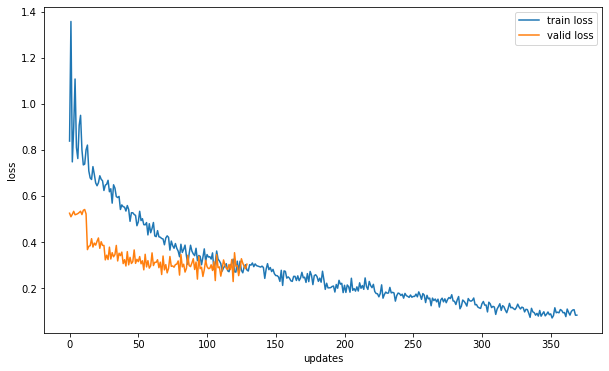

In [32]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss');

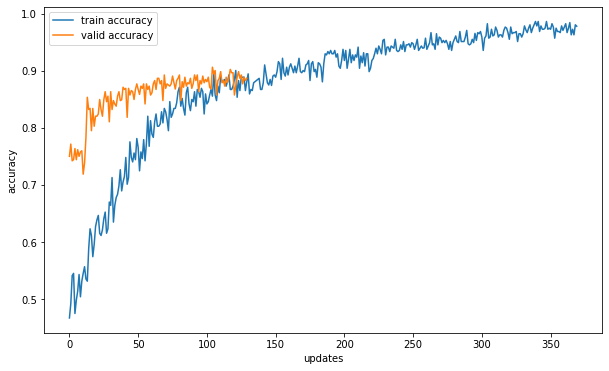

In [33]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

In [34]:
model.load_state_dict(torch.load('cnn.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

test_loss: 0.284, test_acc: 0.879


In [35]:
def predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index):
    tokens = tokenizer(text)
    ids = [vocab[t] for t in tokens]
    if len(ids) < min_length:
        ids += [pad_index] * (min_length - len(ids))
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [36]:
text = "This film is terrible!"
min_length = max(filter_sizes)

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(0, 0.8809852004051208)

In [37]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(1, 0.935274064540863)

In [38]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(0, 0.6467499136924744)

In [39]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(1, 0.6088114380836487)